In [1]:
from graphviz import Digraph

def draw_model():
    dot = Digraph(comment='Composite Delphi Architecture', format='png')
    dot.attr(rankdir='BT')  # Bottom to Top
    dot.attr(splines='ortho') # 직각 선
    
    # 1. 블록 간격 대폭 축소 (Compact Layout)
    dot.attr(nodesep='0.15', ranksep='0.15')
    
    # 2. forcelabels: 라벨 강제 표시 (headlabel 위치 잡는데 도움됨)
    dot.attr(forcelabels='true')

    colors = {
        'input': '#F8DDCC',    # Input/Embedding
        'attention': '#FDEBD0', # Attention
        'moe': '#8a9ecf',       # MoE / FFN
        'norm': '#FEF9E7',      # RMSNorm
        'ffn': '#6f7fb2',   # Output Probs
        'linear': '#E8DAEF',    # Linear Heads
        'box': '#F2F3F4',       # Cluster Background
        'softmax': '#c9e2c9',
        'exponential': '#f29596',
        'linear_func': '#fcdeb3',
        'age': '#FF9999'        # Age Encoding (붉은 계열)
    }
    
    node_attr = {'style': 'filled,rounded', 'shape': 'box', 'fontname': 'Helvetica'}
    edge_attr = {'fontname': 'Helvetica', 'fontsize': '10', 'arrowsize': '0.5'} 
    edge_attr2 = {'fontname': 'Helvetica', 'fontsize': '10', 'arrowsize': '0'} 

    # 1. 입력 레이어 (Inputs & Embeddings)
    with dot.subgraph(name='cluster_inputs') as c:
        c.attr(style='invis')
        
        # 메인 입력 (Data, Shift, Total)
        c.node('Inputs', 'Inputs', 
               fillcolor='white', shape='plaintext', fontname='Helvetica')
        
        # Token Embedding (메인 흐름)
        c.node('CompEmb', 'Token Embedding', 
               fillcolor=colors['input'], **node_attr, height='0.3')
        
        # Add Node (+)
        c.node('InputAdd', '+', shape='circle', fixedsize='true', width='0.4', style='solid', fontname='Helvetica')
        
        # Age Encoding (측면 배치 - 붉은 원형)
        c.node('AgeEmb', 'Age\\nEncoding', shape='circle', 
               fillcolor=colors['age'], style='filled', fixedsize='true', width='0.9', fontname='Helvetica')

        # 메인 흐름을 중심에 배치: Inputs -> Emb -> Add
        with c.subgraph() as s:
            s.attr(rank='same')
            s.node('Inputs')
            s.node('CompEmb')
        
        c.edge('Inputs', 'CompEmb', **edge_attr)
        c.edge('CompEmb', 'InputAdd', **edge_attr)
        
        # Age Encoding을 InputAdd와 같은 높이에 배치하되, 메인 흐름은 중심 유지
        with c.subgraph() as s:
            s.attr(rank='same')
            s.node('AgeEmb')
            s.node('InputAdd')
        c.edge('AgeEmb', 'InputAdd', **edge_attr)

    # 2. Transformer 블록
    with dot.subgraph(name='cluster_layer') as c:
        c.attr(color='black', style='rounded', bgcolor=colors['box'], fontname='Helvetica')
        
        c.node('Norm1', 'RMSNorm', fillcolor=colors['norm'], height='0.3', **node_attr)
        c.node('MaskedAttn', 'Masked Grouped\\nQuery Attention (GQA)\\n(+RoPE, Sliding Window)', 
               fillcolor=colors['attention'], **node_attr)
        c.node('Norm2', 'RMSNorm', fillcolor=colors['norm'], height='0.3', **node_attr)
        c.node('MoE', 'Mixture of Experts', height='0.3',
               fillcolor=colors['moe'], **node_attr)

        c.edge('Norm1', 'MaskedAttn', **edge_attr)
        
        # [핵심 수정] xlabel -> headlabel로 변경 및 위치 미세 조정
        c.edge('MaskedAttn', 'Norm2', **edge_attr)
        
        c.edge('Norm2', 'MoE', **edge_attr)

    # 3. 출력 헤드
    with dot.subgraph(name='cluster_outputs') as c:
        c.attr(style='invis')
        
        c.node('FinalNorm', 'RMSNorm', fillcolor=colors['norm'], height='0.3', **node_attr)
        
        heads = ['DATA', 'SHIFT', 'TOTAL', 'TIME']
        descriptions = [
            'Next disease\\nor drug event', 
            'Dose\\nchange', 
            'Days of\\nmedication', 
            'Time to\\nevent'
        ]
        
        # 각 출력 헤드: Linear -> AF -> Out 수직 타워, 같은 열은 group으로 정렬
        for h, d in zip(heads, descriptions):
            g = f'col_{h}'
            
            # --- Standard Path Nodes ---
            # Linear 레이어
            dot.node(f'Linear_{h}', 'MLP', height='0.2', fillcolor=colors['ffn'], group=g, **node_attr)
            
            # Activation Function 레이어
            if h == 'TOTAL':
                dot.node(f'AF_{h}', 'linear', height='0.2', fillcolor=colors['linear_func'], group=g, **node_attr)
                dot.node(f'Out_{h}', f'{d}', fillcolor=colors['linear_func'], width='1.3', group=g, **node_attr)
            elif h == 'TIME':
                dot.node(f'AF_{h}', 'exponential', height='0.2', fillcolor=colors['exponential'], group=g, **node_attr)
                dot.node(f'Out_{h}', f'{d}', fillcolor=colors['exponential'], width='1.3', group=g, **node_attr)
            else:
                dot.node(f'AF_{h}', 'softmax', height='0.2', fillcolor=colors['softmax'], group=g, **node_attr)
                dot.node(f'Out_{h}', f'{d}', fillcolor=colors['softmax'], width='1.3', group=g, **node_attr)
            
            # --- Standard Path Connections ---
            dot.edge(f'Linear_{h}', f'AF_{h}', **{**edge_attr2, 'weight': '5'})
            dot.edge(f'AF_{h}', f'Out_{h}', **{**edge_attr2, 'weight': '5'})

        # Linear 층: 같은 높이, 수평 정렬
        with c.subgraph() as s:
            s.attr(rank='same')
            for h in heads:
                s.node(f'Linear_{h}')
            for i in range(len(heads) - 1):
                s.edge(f'Linear_{heads[i]}', f'Linear_{heads[i+1]}', style='invis', weight='10')
        
        # AF 층: 같은 높이, 수평 정렬
        with c.subgraph() as s:
            s.attr(rank='same')
            for h in heads:
                s.node(f'AF_{h}')
            for i in range(len(heads) - 1):
                s.edge(f'AF_{heads[i]}', f'AF_{heads[i+1]}', style='invis', weight='10')
        
        # Output 층: 같은 높이, 수평 정렬
        with c.subgraph() as s:
            s.attr(rank='same')
            for h in heads:
                s.node(f'Out_{h}')
            for i in range(len(heads) - 1):
                s.edge(f'Out_{heads[i]}', f'Out_{heads[i+1]}', style='invis', weight='10')

    # --- 전체 흐름 연결 ---
    dot.edge('InputAdd', 'Norm1', **edge_attr)
    
    # [핵심 수정] xlabel -> headlabel로 변경
    dot.edge('MoE', 'FinalNorm', **edge_attr) 
    
    for h in heads:
        dot.edge('FinalNorm', f'Linear_{h}', **edge_attr)

    return dot


In [2]:
graph = draw_model()

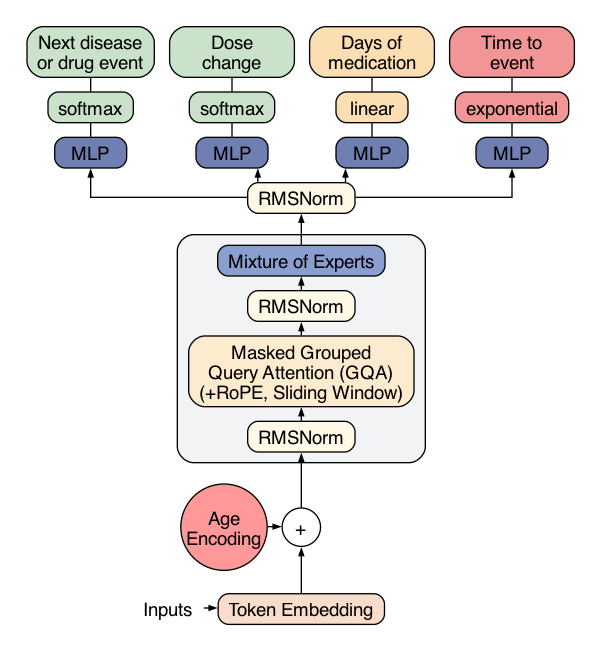

In [3]:
from IPython.display import Image, display
from PIL import Image as PILImage
import io

# Render to PNG bytes
png_data = graph.pipe(format='png')
img = PILImage.open(io.BytesIO(png_data))
# Save with high DPI (metadata only, doesn't change actual resolution)
img.save('composite_delphi_transformer_style.png', dpi=(900, 900))
display(Image('composite_delphi_transformer_style.png'))